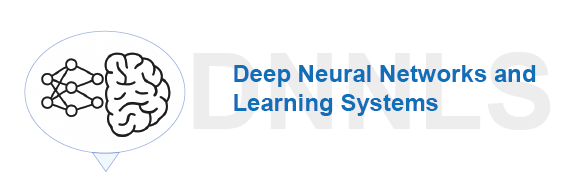

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [1]:
# @title Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
import os

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## 1.1 Loading and saving data

In [2]:
# @title Setting up google drive to save checkpoints

# This will prompt you to authorize Google Drive access
drive.mount('/content/gdrive')

def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="autoencoder_checkpoint.pth"):
    """
    Saves the checkpoint directly to a specified folder in your mounted Google Drive.
    """
    # 1. Define the full Google Drive path
    # 'DL_Checkpoints' is the folder you want to save to inside your Drive
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'

    # Ensure the directory exists before attempting to save
    os.makedirs(drive_folder, exist_ok=True)

    # 2. Combine the folder and the filename
    full_path = os.path.join(drive_folder, filename)

    # 3. Create the checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # 4. Save the dictionary to the Google Drive path
    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved to Google Drive: {full_path} at epoch {epoch}")


def load_checkpoint_from_drive(model, optimizer=None, filename="autoencoder_checkpoint.pth"):
    """
    Loads a checkpoint from your Google Drive folder into the model and optimizer (if provided).
    """
    # Define the same Google Drive folder path
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    full_path = os.path.join(drive_folder, filename)

    # Check if the checkpoint file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")

    # Load the checkpoint
    checkpoint = torch.load(full_path, map_location=torch.device('cpu'))  # use cuda if available

    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore optimizer state (if provided)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Extract metadata
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {full_path} (epoch {epoch})")

    return model, optimizer, epoch, loss


Mounted at /content/gdrive


We need to define a couple of functions to make our life easier. Feel free to tweak those functions:

In [3]:
# @title Functions to load images and process data


# This function just extracts the tags from the text, don't get distracted by it.
# I changed this function a bit to fix some bugs
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees

        # Method 1: Try to get image attribute directly
        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break

        # Method 2: Extract from the tag string using regex
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)

        # Method 3: Fallback - use sequential numbering
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements using BeautifulSoup directly
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

# This is an utility function to show images.
# Why do we need to do all this?
def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  """
  De-normalize the image (if necessary) and show image
  """
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))



Now we load dataset from HuggingFace:

In [4]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

In a previous lab, we analyzed the statistics of the images and figure out that a size of 240x500 could be good enough to standarize, but we will use 60x125. Also, we will restrict ourselves to taking only 5 frames from all the sequences.


## 1.2 Three datasets


---



We will create three different dataset objects and the corresponding loaders for performing multiple tasks

In [5]:
# @title Main dataset
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer):
        super(SequencePredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        # Potential experiments: Try other transforms!
        self.transform = transforms.Compose([
          transforms.Resize((60, 125)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      frame_tensors = []
      description_list = []

      for frame_idx in range(4):
        image = FT.equalize(frames[frame_idx])
        input_frame = self.transform(image)
        frame_tensors.append(input_frame)

        # Potential experiments: Try using the other attributes in your training
        # objects = self.image_attributes[frame_idx]["objects"]
        # actions = self.image_attributes[frame_idx]["actions"]
        # locations = self.image_attributes[frame_idx]["locations"]

        description = self.image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

        description_list.append(input_ids.squeeze(0))


      image_target = FT.equalize(frames[4])
      image_target = self.transform(image_target)
      text_target = self.image_attributes[4]["description"]

      target_ids = tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

      sequence_tensor = torch.stack(frame_tensors)  # shape: (num_frames, C, H, W)
      description_tensor = torch.stack(description_list) # (num_frames, max_length)

      return (sequence_tensor, # Returning the image
              description_tensor, # Returning the whole description
              image_target, # Image target
              target_ids) # Text target



We will use text autoencoding (reconstructing the same text) to develop representations of the text (I provide some existing weights for this, but you can train your own)

In [6]:
# @title Text task dataset (text autoencoding)
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      # Pick
      frame_idx = np.random.randint(0, 5)
      description = self.image_attributes[frame_idx]["description"]

      return description  # Returning the whole description


And also a dataset for a potential image autoencoder task if you want to develop some visual features before training the whose archicture.

In [7]:
# @title Dataset for image autoencoder task
class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.Resize((240, 500)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the autoencoder

      return input_frame, # Returning the image

## 1.3 Creating and testing our dataset objects and loaders


---



In [8]:
# @title For the Sequence prediction task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
sp_train_dataset = SequencePredictionDataset(train_dataset, tokenizer) # Instantiate the train dataset
sp_test_dataset = SequencePredictionDataset(test_dataset, tokenizer) # Instantiate the test dataset

# Let's do things properly, we will also have a validation split
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(sp_train_dataset))
val_size = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])

# Instantiate the dataloaders
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
# We will use the validation set to visualize the progress.
val_dataloader = DataLoader(val_subset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(sp_test_dataset, batch_size=4, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
# @title For the text task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

In [10]:
# @title For the image autoencoder task
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=4, shuffle=True)

Description:  torch.Size([4, 120])
torch.Size([8, 4, 3, 60, 125])
torch.Size([8, 4, 120])


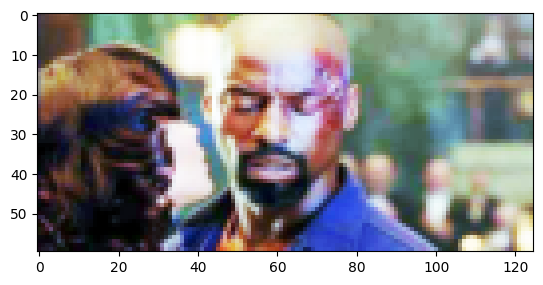

In [11]:
# @title Testing some of the outputs of the SP dataset
frames, descriptions, image_target, text_target = sp_train_dataset[np.random.randint(0,400)]

print("Description: ", descriptions.shape)
figure, ax = plt.subplots(1,1)
show_image(ax, image_target)

# Do some tests on the batches (try with batch size small)
frames, descriptions, image_target, text_target = next(iter(train_dataloader))
print(frames.shape)
print(descriptions.shape)

I will leave the test of the other datasets to you.

# **Chapter 2: Models**


---



We provide a simple text encoder based on a recurrent neural network (LSTM). Feel free to provide your own text encoder.

## 2.1 The NLP models

In [12]:
# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    """
      Encodes a sequence of tokens into a latent space representation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    """
      Decodes a latent space representation into a sequence of tokens.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

# We create the basic text autoencoder (a special case of a sequence to sequence model)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        # input_seq and target_seq are both your 'input_ids'
        # 1. Encode the input sequence
        _enc_out, hidden, cell = self.encoder(input_seq)

        # 2. Create the "shifted" decoder input for teacher forcing.
        # We want to predict target_seq[:, 1:]
        # So, we feed in target_seq[:, :-1]
        # (i.e., feed "[SOS], hello, world" to predict "hello, world, [EOS]")
        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)

        # predictions shape will be (batch_size, seq_len-1, vocab_size)
        return predictions


In [13]:
class BaselineSequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder, latent_dim):
        super().__init__()

        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder

        fusion_dim = latent_dim * 2
        self.temporal_rnn = nn.GRU(fusion_dim, latent_dim, batch_first=True)


        self.attention = Attention(latent_dim)

        self.projection = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU()
        )

        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder = text_autoencoder.decoder

        self.fused_to_h0 = nn.Linear(latent_dim, latent_dim)
        self.fused_to_c0 = nn.Linear(latent_dim, latent_dim)

    def forward(self, image_seq, text_seq, target_seq):
        b, s, C, H, W = image_seq.shape

        # Flatten batch & sequence for encoders
        img_flat = image_seq.view(b * s, C, H, W)
        txt_flat = text_seq.view(b * s, -1)

        # Encode
        z_v = self.image_encoder(img_flat)
        _, h, c = self.text_encoder(txt_flat)

        # Fuse visual + text
        z_fused = torch.cat((z_v, h.squeeze(0)), dim=1)
        z_fused = z_fused.view(b, s, -1)

        # Temporal modeling
        zseq, h = self.temporal_rnn(z_fused)
        h = h.squeeze(0)

        # Attention now exists
        context = self.attention(zseq)

        # Final latent
        z = self.projection(torch.cat((h, context), dim=1))

        # Decode image
        pred_image_content, pred_image_context = self.image_decoder(z)

        # Prepare text decoder states
        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        decoder_input = target_seq[:, :, :-1].squeeze(1)
        predicted_text, _, _ = self.text_decoder(decoder_input, h0, c0)

        return pred_image_content, pred_image_context, predicted_text, h0, c0


In [14]:
# @title Utility functions for NLP tasks
def generate(model, hidden, cell, max_len, sos_token_id, eos_token_id):
      """
        This function generates a sequence of tokens using the provided decoder.
      """
      # Ensure the model is in evaluation mode
      model.eval()

      # 2. SETUP DECODER INPUT
      # Start with the SOS token, shape (1, 1)
      dec_input = torch.tensor([[sos_token_id]], dtype=torch.long, device=device)
      # hidden = torch.zeros(1, 1, hidden_dim, device=device)
      # cell = torch.zeros(1, 1, hidden_dim, device=device)

      generated_tokens = []

      # 3. AUTOREGRESSIVE LOOP
      for _ in range(max_len):
          with torch.no_grad():
              # Run the decoder one step at a time
              # dec_input is (1, 1) here—it's just the last predicted token
              prediction, hidden, cell = model(dec_input, hidden, cell)

          logits = prediction.squeeze(1) # Shape (1, vocab_size)
          temperature = 0.9 # <--- Try a value between 0.5 and 1.0

          # 1. Divide logits by temperature
          # 2. Apply softmax to get probabilities
          # 3. Use multinomial to sample one token based on the probabilities
          probabilities = torch.softmax(logits / temperature, dim=-1)
          next_token = torch.multinomial(probabilities, num_samples=1)

          token_id = next_token.squeeze().item()

          # Check for the End-of-Sequence token
          if token_id == eos_token_id:
              break

          if token_id == 0 or token_id == sos_token_id:
              continue

            # Append the predicted token
          generated_tokens.append(token_id)

          # The predicted token becomes the input for the next iteration
          dec_input = next_token

      # Return the list of generated token IDs
      return generated_tokens


In [15]:
# @title Do some tests
# desc = text_dataset[np.random.randint(0, 100)]
# print(f"Input: {desc}")
# input_ids = tokenizer(desc, return_tensors="pt",  padding=True, truncation=True).input_ids
# input_ids = input_ids.to(device)
# generated_tokens = generate(model, hidden, cell, max_len=100, sos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)
# print("Output: ", tokenizer.decode(generated_tokens))

## 2.2 The Vision models

In [16]:
# @title The visual autoencoder
class Backbone(nn.Module):
    """
      Main convolutional blocks for our CNN
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(Backbone, self).__init__()
        # Encoder convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=2, padding=3),
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),

            nn.Conv2d(16, 32, 5, stride=2, padding=2),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.1),
        )

        # Calculate flattened dimension for linear layer
        self.flatten_dim = 64 * output_w * output_h
        # Latent space layers
        self.fc1 = nn.Sequential(nn.Linear(self.flatten_dim, latent_dim), nn.ReLU())


    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, self.flatten_dim)  # flatten for linear layer
        z = self.fc1(x)
        return z

class VisualEncoder(nn.Module):
    """
      Encodes an image into a latent space representation. Note the two pathways
      to try to disentangle the mean pattern from the image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualEncoder, self).__init__()

        self.context_backbone = Backbone(latent_dim, output_w, output_h)
        self.content_backbone = Backbone(latent_dim, output_w, output_h)

        self.projection = nn.Linear(2*latent_dim, latent_dim)
    def forward(self, x):
        z_context = self.context_backbone(x)
        z_content = self.content_backbone(x)
        z = torch.cat((z_content, z_context), dim=1)
        z = self.projection(z)
        return z

class VisualDecoder(nn.Module):
    """
      Decodes a latent representation into a content image and a context image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualDecoder, self).__init__()
        self.imh = 60
        self.imw = 125
        self.flatten_dim = 64 * output_w * output_h
        self.output_w = output_w
        self.output_h = output_h

        self.fc1 = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
          nn.GroupNorm(8, 32),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
          nn.GroupNorm(8, 16),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=(1, 1)),
          nn.Sigmoid() # Use nn.Tanh() if your data is normalized to [-1, 1]
      )

    def forward(self, z):
      x = self.fc1(z)

      x_content = self.decode_image(x)
      x_context = self.decode_image(x)

      return x_content, x_context

    def decode_image(self, x):
      x = x.view(-1, 64, self.output_w, self.output_h)      # reshape to conv feature map
      x = self.decoder_conv(x)
      x = x[:, :, :self.imh, :self.imw]          # crop to original size if needed
      return x

class VisualAutoencoder( nn.Module):
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualAutoencoder, self).__init__()
        self.encoder = VisualEncoder(latent_dim, output_w, output_h)
        self.decoder = VisualDecoder(latent_dim, output_w, output_h)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat



## 2.3 The main architecture


In [17]:
# @title A simple attention architecture

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # This "attention" layer learns a query vector
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1) # Over the sequence length

    def forward(self, rnn_outputs):
        # rnn_outputs shape: [batch, seq_len, hidden_dim]

        # Pass through linear layer to get "energy" scores
        energy = self.attn(rnn_outputs).squeeze(2) # Shape: [batch, seq_len]

        # Get attention weights
        attn_weights = self.softmax(energy) # Shape: [batch, seq_len]

        # Apply weights
        # attn_weights.unsqueeze(1) -> [batch, 1, seq_len]
        # bmm with rnn_outputs -> [batch, 1, hidden_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs)

        # Squeeze to get final context vector
        return context.squeeze(1) # Shape: [batch, hidden_dim]

In [18]:
# @title The main sequence predictor model

class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder, latent_dim,
                 gru_hidden_dim):
        super(SequencePredictor, self).__init__()

        # --- 1. Static Encoders ---
        # (These process one pair at a time)
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder

        # --- 2. Temporal Encoder ---
        # (This processes the sequence of pairs)
        fusion_dim = latent_dim * 2 # z_visual + z_text
        self.temporal_rnn = nn.GRU(fusion_dim, latent_dim, batch_first=True)

        # --- 3. Attention ---
        self.attention = Attention(gru_hidden_dim)

        # --- 4. Final Projection ---
        # cat(h, context) -> gru_hidden_dim * 2
        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, latent_dim),
            nn.ReLU()
        )

        # --- 5. Decoders ---
        # (These predict the *next* item)
        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder = text_autoencoder.decoder

        self.fused_to_h0 = nn.Linear(latent_dim, 16)
        self.fused_to_c0 = nn.Linear(latent_dim, 16)

    def forward(self, image_seq, text_seq, target_seq):
        # image_seq shape: [batch, seq_len, C, H, W]
        # text_seq shape:  [batch, seq_len, text_len]
        # target_text_for_teacher_forcing: [batch, text_len] (This is the last text)

        batch_size, seq_len, C, H, W = image_seq.shape

        # --- 1 & 2: Run Static Encoders over the sequence ---
        # We can't pass a 5D/4D tensor to the encoders.
        # We "flatten" the batch and sequence dimensions.

        # Reshape for image_encoder
        img_flat = image_seq.view(batch_size * seq_len, C, H, W)
        # Reshape for text_encoder
        txt_flat = text_seq.view(batch_size * seq_len, -1) # -1 infers text_len

        # Run encoders
        z_v_flat = self.image_encoder(img_flat) # Shape: [b*s, latent]
        _, hidden, cell = self.text_encoder(txt_flat) # Shape: [b*s, latent]

        # Combine
        z_fusion_flat = torch.cat((z_v_flat, hidden.squeeze(0)), dim=1) # Shape: [b*s, fusion_dim]

        # "Un-flatten" back into a sequence
        z_fusion_seq = z_fusion_flat.view(batch_size, seq_len, -1) # Shape: [b, s, fusion_dim]

        # --- 3. Run Temporal Encoder ---
        # zseq shape: [b, s, gru_hidden]
        # h    shape: [1, b, gru_hidden]
        zseq, h = self.temporal_rnn(z_fusion_seq)
        h = h.squeeze(0) # Shape: [b, gru_hidden]

        # --- 4. Attention ---
        context = self.attention(zseq) # Shape: [b, gru_hidden]

        # --- 5. Final Prediction Vector (z) ---
        z = self.projection(torch.cat((h, context), dim=1)) # Shape: [b, joint_latent_dim]

        # --- 6. Decode (Predict pk) ---
        pred_image_content, pred_image_context = self.image_decoder(z)

        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        decoder_input = target_seq[:, :,:-1].squeeze(1)

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predicted_text_logits_k, _hidden, _cell = self.text_decoder(decoder_input, h0, c0)

        return pred_image_content, pred_image_context, predicted_text_logits_k,h0, c0

# **Chapter 3: Training routines**


---




In [19]:
# @title Training utility functions: To initialize and to visualize the progress


def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias, 0)


# Plots four images and their reconstructions
def validation( model, data_loader ):
  model.eval()
  with torch.no_grad():
    frames, descriptions, image_target, text_target = next(iter(data_loader))

    descriptions = descriptions.to(device)
    frames = frames.to(device)
    image_target = image_target.to(device)
    text_target = text_target.to(device)

    predicted_image_k,context_image, _, hidden, cell = model(frames, descriptions, text_target)

    figure, ax = plt.subplots(2, 6, figsize=(20, 5), gridspec_kw={'height_ratios': [2, 1.5]})

    for i in range(4):
      im = frames[0, i, :, :, :].cpu()
      show_image(ax[0,i], im )
      ax[0,i].set_aspect('auto')
      ax[0,i].axis('off')
      wrapped_text = textwrap.fill(tokenizer.decode(descriptions[0, i, :], skip_special_tokens=True), width=40)

      ax[1,i].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=True
        )

      ax[1,i].axis('off') # Hide axes for the text subplot

    show_image(ax[0,4], image_target[0].cpu())
    ax[0,4].set_title('Target')
    ax[0,4].set_aspect('auto')
    ax[0,4].axis('off')
    text_target = text_target.squeeze(1)

    wrapped_text = textwrap.fill(tokenizer.decode(text_target[0], skip_special_tokens=True), width=40)
    ax[1,4].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False)
    ax[1,4].axis('off')
    output = context_image[0, :, :, :].cpu()
    show_image(ax[0,5], output)
    ax[0,5].set_title('Predicted')
    ax[0,5].set_aspect('auto')
    ax[0,5].axis('off')

    generated_tokens = generate(model.text_decoder,
                                hidden[:,0, :].unsqueeze(1),
                                cell[:, 0, :].unsqueeze(1),
                                max_len=150,
                                sos_token_id=tokenizer.cls_token_id,
                                eos_token_id=tokenizer.sep_token_id)

    wrapped_text = textwrap.fill(tokenizer.decode(generated_tokens), width=40)

    ax[1,5].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False )
    ax[1,5].axis('off')
    plt.tight_layout()
    plt.show()


## 3.1 Initialization and setup

In [20]:
# @title Variables and initial setup
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_EPOCHS = 5
emb_dim = 16
latent_dim = 16
num_layers = 1
dropout = True

In [21]:
# @title Initializing the NLP models
encoder = EncoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
decoder = DecoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
text_autoencoder = Seq2SeqLSTM(encoder, decoder).to(device)
text_autoencoder, _, _, _ = load_checkpoint_from_drive(text_autoencoder, None, filename='text_autoencoder.pth')

total_params = sum(p.numel() for p in text_autoencoder.parameters())
print(f"Total parameters (Not trainable): {total_params}")
# Deactivating training from this model for efficiency (although not ideal)
for param in text_autoencoder.parameters():
        param.requires_grad = False


Checkpoint loaded from: /content/gdrive/MyDrive/DL_Checkpoints/text_autoencoder.pth (epoch 15)
Total parameters (Not trainable): 1499930


In [22]:
# @title Initializing visual models
visual_autoencoder = VisualAutoencoder(latent_dim=16)
visual_autoencoder.apply(init_weights)

total_params = sum(p.numel() for p in visual_autoencoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in visual autoencoder: {total_params}")

Total trainable parameters in visual autoencoder: 503539


In [23]:
# @title Initialize the main architecture
# We put all the sizes the same, not ideal as well
sequence_predictor = SequencePredictor(visual_autoencoder, text_autoencoder, latent_dim, latent_dim)
sequence_predictor.to(device)

enhanced_model = sequence_predictor

# # Print number of trainable parameters
total_params = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
print(f"Total trainable parameters in the whole model: {total_params}")

# Print model size
total_params = sum(p.numel() for p in sequence_predictor.parameters())
print(f"Total parameters: {total_params}")

Total trainable parameters in the whole model: 507028
Total parameters: 2006958


In [24]:
baseline_model = BaselineSequencePredictor(
    visual_autoencoder,
    text_autoencoder,
    latent_dim
).to(device)


## 3.2 Training loops

In [25]:
# @title Training tools
criterion_images = nn.L1Loss()
criterion_ctx = nn.MSELoss()
criterion_text = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
optimizer = torch.optim.Adam(sequence_predictor.parameters(), lr=0.001)

In [26]:
# @title Training loop for the sequence predictor
# Instantiate the model, define loss and optimizer

sequence_predictor.train()
losses = []

for epoch in range(N_EPOCHS):

    running_loss = 0.0
    for frames, descriptions, image_target, text_target  in train_dataloader:

      # Send images and tokens to the GPU
      descriptions = descriptions.to(device)
      frames = frames.to(device)
      image_target = image_target.to(device)
      text_target = text_target.to(device)
      # Predictions from our model
      pred_image_content, pred_image_context, predicted_text_logits_k, _, _ = sequence_predictor(frames, descriptions, text_target)
      # Computing losses
      # Loss for image reconstruction
      loss_im = criterion_images(pred_image_content, image_target)
      # Loss for the average pattern the images contain
      mu_global = frames.mean(dim=[0, 1])
      mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
      loss_context = criterion_ctx(pred_image_context, mu_global)
      # Loss function for the text prediction
      prediction_flat = predicted_text_logits_k.reshape(-1, tokenizer.vocab_size)
      target_labels = text_target.squeeze(1)[:, 1:] # Slice to get [8, 119]
      target_flat = target_labels.reshape(-1)
      loss_text = criterion_text(prediction_flat, target_flat)
      # Combining the losses
      loss = loss_im + loss_text + 0.2*loss_context
      # Optimizing
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * frames.size(0)

    # checking model performance on validation set
    sequence_predictor.eval()
    print("Validation on training dataset")
    print( "----------------")
    validation( sequence_predictor, train_dataloader )
    print("Validation on validation dataset")
    print( "----------------")
    validation( sequence_predictor, val_dataloader)
    sequence_predictor.train()

    # scheduler.step()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Loss: {epoch_loss:.4f}')

    if epoch % 5 == 0:
      save_checkpoint_to_drive(sequence_predictor, optimizer, epoch, epoch_loss, filename=f"sequence_predictor.pth")

# Do better plots
plt.plot(losses)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [27]:
# @title Example text reconstruction task

# Unfreeze the text autoencoder so gradients flow
for param in text_autoencoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_autoencoder.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    text_autoencoder.train()
    epoch_loss = 0
    for description in text_dataloader:
        # Move the "sentences" to device
        input_ids = tokenizer(description, return_tensors="pt",  padding=True, truncation=True).input_ids
        input_ids = input_ids.to(device)

        # zero the grad, then forward pass
        optimizer.zero_grad()
        outputs = text_autoencoder(input_ids, input_ids)
        # compute the loss: compare 3D logits to 2D targets
        loss = loss_fn(outputs.reshape(-1, tokenizer.vocab_size), input_ids[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{N_EPOCHS}; Avg loss {epoch_loss/len(text_dataloader)}; Latest loss {loss.item()}")
    torch.save(text_autoencoder.state_dict(), f"seq2seq-epoch-{epoch+1}.pth")

# # saving checkpoint to drive
save_checkpoint_to_drive(text_autoencoder, optimizer, 3*N_EPOCHS, loss, filename = "text_autoencoder.pth")

Epoch 1/5; Avg loss 4.563138782441079; Latest loss 4.789369106292725
Epoch 2/5; Avg loss 4.478506288012943; Latest loss 4.702242851257324
Epoch 3/5; Avg loss 4.409096595403311; Latest loss 4.749024868011475
Epoch 4/5; Avg loss 4.334275923333727; Latest loss 4.067215919494629
Epoch 5/5; Avg loss 4.283103815338633; Latest loss 4.465517520904541
Checkpoint saved to Google Drive: /content/gdrive/MyDrive/DL_Checkpoints/text_autoencoder.pth at epoch 15


In [28]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1b30ed2e6bd57155abedbdf0fbf663d8fbbc26676283c2caf1aa03ccc0bd0bee
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [29]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # optional but recommended

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [30]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

def evaluate_text(model, dataloader):
    model.eval()

    bleu_scores = []
    meteor_scores = []
    rouge_l_scores = []

    smooth = SmoothingFunction().method1
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    with torch.no_grad():
        for frames, descriptions, image_target, text_target in dataloader:
            frames = frames.to(device)
            descriptions = descriptions.to(device)
            text_target = text_target.to(device)

            outputs = model(frames, descriptions, text_target)

            # Extract hidden states (single sample)
            h0 = outputs[-2][:, 0:1, :]
            c0 = outputs[-1][:, 0:1, :]

            generated_tokens = generate(
                model.text_decoder,
                h0,
                c0,
                max_len=120,
                sos_token_id=tokenizer.cls_token_id,
                eos_token_id=tokenizer.sep_token_id
            )

            # Decode text
            pred_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
            ref_text = tokenizer.decode(
                text_target[0].squeeze(0),
                skip_special_tokens=True
            )

            # FORCE TOKENIZATION (this is the critical fix)
            pred_tokens = pred_text.split()
            ref_tokens = ref_text.split()

            if len(pred_tokens) == 0:
                continue  # skip empty generations safely

            # BLEU-2 with smoothing
            bleu_scores.append(
                sentence_bleu(
                    [ref_tokens],
                    pred_tokens,
                    weights=(0.5, 0.5),
                    smoothing_function=smooth
                )
            )

            # METEOR (tokenized only)
            meteor_scores.append(
                meteor_score([ref_tokens], pred_tokens)
            )

            # ROUGE-L
            rouge_l_scores.append(
                scorer.score(ref_text, pred_text)['rougeL'].fmeasure
            )

    return {
        "BLEU": float(np.mean(bleu_scores)) if bleu_scores else 0.0,
        "METEOR": float(np.mean(meteor_scores)) if meteor_scores else 0.0,
        "ROUGE-L": float(np.mean(rouge_l_scores)) if rouge_l_scores else 0.0
    }


In [31]:
baseline_scores = evaluate_text(baseline_model, test_dataloader)
enhanced_scores = evaluate_text(sequence_predictor, test_dataloader)

print("Baseline:", baseline_scores)
print("Enhanced:", enhanced_scores)


Baseline: {'BLEU': 0.036833416491762694, 'METEOR': 0.08877674579168798, 'ROUGE-L': 0.12041918263560572}
Enhanced: {'BLEU': 0.04745322543296154, 'METEOR': 0.1107143507251523, 'ROUGE-L': 0.1497407477562115}


In [32]:
difference = {
    metric: enhanced_scores[metric] - baseline_scores[metric]
    for metric in baseline_scores.keys()
}

print("Difference (Enhanced − Baseline):")
for k, v in difference.items():
    print(f"{k}: {v:.4f}")


Difference (Enhanced − Baseline):
BLEU: 0.0106
METEOR: 0.0219
ROUGE-L: 0.0293


In [33]:
# @title Image reonstruction task

# To-Do: Use previous labs if you want to pretrain your visual encoder

# **Appendix**

This code computes the average images in case you want to use them. Notice that the average should be all zeros!

In [34]:
# @title Computing and showing average images
N = 1000
H, W = 60, 125

# Accumulators (mean & variance)
avg_images = [torch.zeros((3, H, W)) for _ in range(5)]
sum_sq_diff = [torch.zeros((3, H, W)) for _ in range(5)]

# Use the same resize transform as your dataset
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

print("Starting Pass 1: Calculating Mean...")

for i in range(N):
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])    # Now always 3×60×125
        avg_images[j] += image

# Compute mean
for j in range(5):
    avg_images[j] /= N

print("Starting Pass 2: Calculating Variance...")

for i in range(N):
    sequence = train_dataset[i]["images"]

    for j in range(5):
        image = transform(sequence[j])    # Same transform
        diff = image - avg_images[j]
        sum_sq_diff[j] += diff * diff

std_images = []
for j in range(5):
    variance = sum_sq_diff[j] / N
    std_images.append(torch.sqrt(variance))


Starting Pass 1: Calculating Mean...
Starting Pass 2: Calculating Variance...
